# Zad. 1: Proporcja osób chorych do zdrowych - Model SIS

## Dane
- $S_0 = 150$ (zdrowi)
- $I_0 = 120$ (chorzy)
- $N = S + I = 270$ (stała populacja)
- dziennie choruje $20\%$ zdrowych $\Rightarrow \alpha = 0.2$
- dziennie zdrowieje $10\%$ chorych $\Rightarrow \gamma = 0.1$

## Dlaczego uproszczony, liniowy model SIS?
- Dwa stany: zdrowi ($S$) i chorzy ($I$).
- Po wyzdrowieniu wracamy do $S$ (brak trwałej odporności) $\Rightarrow$ możliwe ponowne zachorowanie.

## Założenia
- Populacja $N$ jest stała (brak urodzeń, zgonów, migracji).
- Przepływy są procentowe „na dobę”:
  - zachorowania: $S \to I$ z intensywnością $\alpha S$
  - wyzdrowienia: $I \to S$ z intensywnością $\gamma I$


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parametry (na dobę)
alpha = 0.20  # 20% zdrowych choruje dziennie: S -> I
gamma = 0.10  # 10% chorych zdrowieje dziennie: I -> S

# warunki początkowe
S0 = 150
I0 = 120
N = S0 + I0  # stała populacja

# czas symulacji
t = np.linspace(0, 30, 31)

# równania różniczkowe
def SIS_linear(y, t, alpha, gamma):
    S, I = y
    dSdt = -alpha * S + gamma * I
    dIdt =  alpha * S - gamma * I
    return dSdt, dIdt

# rozwiązanie ODE
solution = odeint(SIS_linear, [S0, I0], t, args=(alpha, gamma))
S, I = solution.T

# równowaga analityczna (przepływy równe)
# alpha*S = gamma*I  => I = (alpha/gamma) * S
S_eq = N / (1 + alpha/gamma)
I_eq = N - S_eq
print(f"Równowaga: S ≈ {S_eq:.2f}, I ≈ {I_eq:.2f} (proporcja S:I = 1:2)")

Równowaga: S ≈ 90.00, I ≈ 180.00 (proporcja S:I = 1:2)


## Równania modelu (ODE)
$$
\frac{dS}{dt} = -\alpha S + \gamma I
$$
$$
\frac{dI}{dt} = \alpha S - \gamma I
$$

## Równowaga
Równowaga = zachorowania = wyzdrowienia:
$$
\alpha S = \gamma I
$$

Dla danych:
$$
0.2S = 0.1I \Rightarrow I = 2S
$$

Z warunku $S + I = 270$:
$$
S^* = 90,\quad I^* = 180
$$

Proporcja w równowadze:
$$
S:I = 1:2
$$

## Wykres

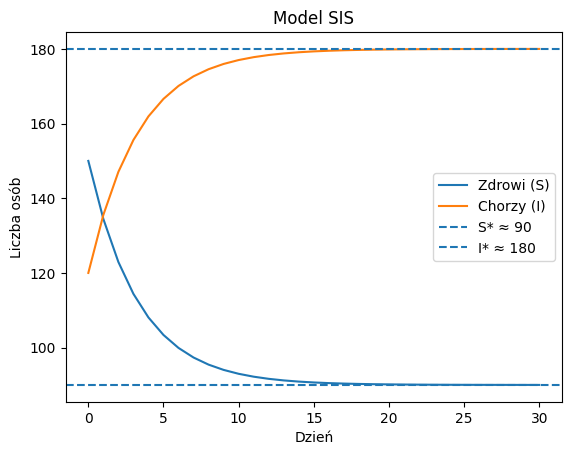

In [ ]:
plt.plot(t, S, label="Zdrowi (S)")
plt.plot(t, I, label="Chorzy (I)")
plt.axhline(S_eq, linestyle="--", label=f"S* ≈ {S_eq:.0f}")
plt.axhline(I_eq, linestyle="--", label=f"I* ≈ {I_eq:.0f}")
plt.xlabel("Dzień")
plt.ylabel("Liczba osób")
plt.title("Model SIS")
plt.legend()
plt.show()

## Interpretacja wykresu
- $S(t)$ maleje z 150 do ok. 90.
- $I(t)$ rośnie z 120 do ok. 180.
- Wypłaszczenie krzywych oznacza dojście do stanu równowagi (brak dalszych zmian liczebności).

## Wnioski
- Ponieważ $\alpha > \gamma$ (0.2 > 0.1), model dąży do większego udziału chorych.
- Układ stabilizuje się w punkcie $S^* = 90$, $I^* = 180$.
- W równowadze dziennie tyle samo osób zachoruje, co wyzdrowieje.


Materiały do Zad 1:
https://czasopisma.ukw.edu.pl/index.php/smis/article/view/1935

# Zad. 2: Wyszukiwarka Hybrydowa: BM25 + Dense Embeddings

Celem było zbudowanie prostej wyszukiwarki tekstowej dla kilku polskich książek (źródło: Wolne Lektury), działającej w trybie CLI (terminal), która zwraca najbardziej pasujące fragmenty tekstu (“chunki”) na podstawie zapytania użytkownika.

Projekt składa się z etapów:
1) Wczytanie dokumentów `.txt` w języku polskim (różne kodowania).
2) Czyszczenie tekstu i przygotowanie chunków.
3) Zbudowanie indeksu leksykalnego (BM25) i semantycznego (embeddingi).
4) Hybrydowe łączenie rankingów (RRF).
5) Prosty interfejs CLI i interpretacja wyników.

## Instalacja zależności

In [ ]:
# !pip install -q rank-bm25 sentence-transformers spacy pandas numpy llama-index-core Unidecode
# !python -m spacy download pl_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 27.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in

## Importy i konfiguracja

In [ ]:
import re
import numpy as np
import pandas as pd
import spacy
import random
from unidecode import unidecode
from pathlib import Path
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer

from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter

## Konfiguracja

Parametr RRF_ALPHA:
*   0 = tylko BM25
*   1 = tylko dense


In [ ]:
nlp = spacy.load("pl_core_news_sm")

DATA_DIR = Path("data")
MODEL_NAME = "paraphrase-multilingual-MiniLM-L12-v2"

SEED = 1

# Chunking
CHUNK_SIZE = 900
CHUNK_OVERLAP = 120

# Retrieval / ranking
CANDIDATES_N = 300
TOP_K = 5

# RRF
RRF_ALPHA = 0.6
RRF_K = 60

print("Konfiguracja:")
print("CHUNK_SIZE:", CHUNK_SIZE)
print("CHUNK_OVERLAP:", CHUNK_OVERLAP)
print("CANDIDATES_N:", CANDIDATES_N)
print("TOP_K:", TOP_K)
print("RRF_ALPHA:", RRF_ALPHA, "RRF_K:", RRF_K)

Konfiguracja:
CHUNK_SIZE: 900
CHUNK_OVERLAP: 120
CANDIDATES_N: 300
TOP_K: 5
RRF_ALPHA: 0.6 RRF_K: 60


## 1. Czyszczenie tekstu - funkcje

In [ ]:
def read_text_robust(path: Path) -> str:
    """
    Wczytuje plik tekstowy, próbując kolejno kilku kodowań.

    Próbuje: UTF-8, CP1250, ISO-8859-2. Jeśli wszystkie zawiodą, wczytuje jako UTF-8
    z ignorowaniem błędów dekodowania.

    Parametry:
        path: Ścieżka do pliku.

    Zwraca:
        Zawartość pliku jako str.
    """
    for enc in ("utf-8", "cp1250", "iso-8859-2"):
        try:
            return path.read_text(encoding=enc)
        except UnicodeDecodeError:
            continue
    return path.read_text(encoding="utf-8", errors="ignore")


def remove_diacritics(text: str) -> str:
    """
    Usuwa znaki diakrytyczne z tekstu (np. ąęłńóśźż -> aelnoszz).

    Parametry:
        text: Tekst wejściowy.

    Zwraca:
        Tekst bez znaków diakrytycznych.
    """
    return unidecode(text)


def clean_boilerplate(raw: str) -> str:
    """
    Minimalne czyszczenie Wolnych Lektur:
    - ucina stopkę od 'Ta lektura, podobnie jak tysiące innych...' do końca
    - usuwa nagłówek do pierwszej linii z ISBN (jeśli ISBN jest w pierwszych ~60 liniach)
    - usuwa separatory typu '-----'
    """
    raw = raw.replace("\r\n", "\n").replace("\r", "\n")

    footer_marker = "Ta lektura, podobnie jak tysiące innych"
    idx_footer = raw.find(footer_marker)
    if idx_footer != -1:
        raw = raw[:idx_footer]

    lines = raw.split("\n")

    cut_idx = None
    for i, ln in enumerate(lines[:60]):
        if "isbn" in ln.lower():
            cut_idx = i + 1
            break
    if cut_idx is not None:
        lines = lines[cut_idx:]

    cleaned = []
    for ln in lines:
        s = ln.strip()
        if s and len(s) >= 3 and all(c in "-—_ " for c in s):
            continue

        cleaned.append(ln)

    text = "\n".join(cleaned)
    text = re.sub(r"\n{3,}", "\n\n", text).strip()
    return text

## Czy usuwanie polskich znaków to dobry pomysł?

To kompromis.

**Plus:** jeśli użytkownik wpisze `ksiazka` albo `książka`, system potraktuje to tak samo i zwróci identyczne wyniki (mniej “pustych” zapytań przez brak ogonków).

**Minus:** tracimy rozróżnienie znaczeń w niektórych słowach, np. `łoś` → `los` (inne znaczenie), więc możemy wprowadzić fałszywe dopasowania.

W praktyce: usuwanie diakrytyków poprawia odporność na błędy w pisowni, ale może pogorszyć precyzję dla wyrazów, gdzie ogonki niosą istotną informację semantyczną.

## 2. Preprocessing na dwie wersje

## Dlaczego preprocessing i chunking różnią się dla dense vs BM25?

- **Dense embeddings:** lepsze wyniki daje większy kontekst (pełniejsze zdania, spójność semantyczna), więc preprocessing jest minimalny.
- **BM25:** wymaga stabilnej reprezentacji tokenów (lematyzacja + usunięcie diakrytyków + filtr tokenów), bo to wpływa bezpośrednio na dopasowanie fraz i odmian.

Wniosek: BM25 jest świetne dla zapytań „keywordowych”, a dense pomaga przy zapytaniach opisowych / semantycznych.


In [ ]:
def preprocess_for_dense(text: str) -> str:
    """
    Przygotowuje tekst pod embeddingi gęste (dense embeddings).

    Wykonuje normalizację białych znaków (wielokrotne spacje/nowe linie -> pojedyncza spacja),
    bez ingerencji w treść zdań i znaczenie.

    Parametry:
        text: Tekst wejściowy.

    Zwraca:
        Tekst z ujednoliconym spacjowaniem.
    """
    text = re.sub(r"\s+", " ", text).strip()
    return text


def preprocess_for_bm25(text: str) -> str:
    """
    spaCy: lematyzacja + filtracja.
    Wynik: tokeny (lematy) oddzielone spacjami.
    """
    doc = nlp(text)

    tokens = []
    for token in doc:
        if token.is_space or token.is_punct or token.is_stop:
            continue

        lemma = token.lemma_.lower()

        if lemma.isdigit():
            continue

        if not token.is_alpha:
            continue

        if len(lemma) < 3:
            continue

        lemma = remove_diacritics(lemma)

        if len(lemma) < 3:
            continue

        tokens.append(lemma)

    return " ".join(tokens)

## 3. Chunkowanie po zdaniach

## Chunking – dlaczego dzielę tekst na fragmenty

Zamiast indeksować całe książki jako pojedyncze dokumenty, dzielę je na chunki (fragmenty):
- zwiększa to precyzję wyników (użytkownik dostaje konkretny fragment),
- umożliwia wyszukiwanie “w środku książki”,
- ułatwia łączenie BM25 i dense na mniejszych jednostkach tekstu.

**Założenie projektowe:** chunk powinien być na tyle krótki, by był “trafną odpowiedzią”, ale na tyle długi, by zawierał kontekst.

In [ ]:
splitter = SentenceSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

def chunk_text(text: str) -> list[str]:
    """Dzieli tekst na mniejsze fragmenty (chunki) przy użyciu `splitter`
    i zwraca listę niepustych kawałków."""
    doc = Document(text=text)
    nodes = splitter.get_nodes_from_documents([doc])
    chunks = [n.get_content().strip() for n in nodes]
    return [c for c in chunks if c]

## 4. Ładowanie danych i tworzenie dataframe

In [ ]:
def extract_metadata(raw: str) -> tuple[str, str]:
    """
    Wyciąga metadane (tytuł i autor) z surowej treści pliku `.txt`
    """
    lines = [ln.strip() for ln in raw.splitlines() if ln.strip()]
    author = lines[0] if len(lines) > 0 else "Unknown"
    title = lines[1] if len(lines) > 1 else "Unknown"
    return title, author


def load_corpus(data_dir: Path) -> pd.DataFrame:

    """
    Ładuje korpus dokumentów tekstowych z katalogu i przygotowuje go do indeksowania.

    Co robi funkcja:
    1) Iteruje po plikach `.txt` w katalogu `data_dir` (posortowane po nazwie).
    2) Wczytuje tekst odpornie na problemy kodowania (`read_text_robust`).
    3) Ekstrahuje metadane (tytuł, autor) z nagłówka pliku (`extract_metadata`).
    4) Czyści tekst z boilerplate (np. stopki/nagłówki serwisu) (`clean_boilerplate`).
    5) Dzieli tekst na fragmenty (chunking) (`chunk_text`).
    6) Dla każdego chunka tworzy dwie reprezentacje:
       - `text_dense`: pod embeddingi (semantyczne wyszukiwanie),
       - `text_bm25`: pod BM25 (leksykalne wyszukiwanie),
       **bez doklejania metadanych** do BM25, aby nie zaburzać dopasowania treści.

    Parametry:
    - data_dir: ścieżka do katalogu z plikami `.txt`.

    Zwraca:
    - DataFrame, gdzie każdy wiersz to jeden chunk z kolumnami:
      doc_id, filename, title, author, chunk_id, text_dense, text_bm25.

    Wyjątki:
    - ValueError: gdy nie znaleziono żadnych rekordów (np. brak plików `.txt` lub pusty folder).
    """

    records = []

    for filepath in sorted(data_dir.glob("*.txt")):
        raw = read_text_robust(filepath)
        title, author = extract_metadata(raw)

        text_clean = clean_boilerplate(raw)
        chunks = chunk_text(text_clean)

        for chunk_id, chunk in enumerate(chunks):
            records.append({
                "doc_id": filepath.stem,
                "filename": filepath.name,
                "title": title,
                "author": author,
                "chunk_id": chunk_id,
                "text_dense": preprocess_for_dense(chunk),
                "text_bm25": preprocess_for_bm25(chunk),
            })

    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError("Brak rekordów – sprawdź folder data/ i pliki .txt")
    return df


df = load_corpus(DATA_DIR)
print("Liczba chunków:", len(df))
print("Liczba dokumentów:", df["doc_id"].nunique())

Liczba chunków: 332
Liczba dokumentów: 5


,doc_id,filename,title,author,chunk_id,text_dense,text_bm25
0,borowski-prosze-panstwa-do-gazu,borowski-prosze-panstwa-do-gazu.txt,Proszę państwa do gazu,Tadeusz Borowski,0,Cały obóz chodził nago. Wprawdzie przeszliśmy ...,oboz chodzic nago wprawdzie przeszc byc odwsze...
1,borowski-prosze-panstwa-do-gazu,borowski-prosze-panstwa-do-gazu.txt,Proszę państwa do gazu,Tadeusz Borowski,1,"Pewnie nigdy nie piłeś, nieprawda? — Nie. Ale ...",pewnie pic byc nieprawda brama przeniesiec buj...
2,borowski-prosze-panstwa-do-gazu,borowski-prosze-panstwa-do-gazu.txt,Proszę państwa do gazu,Tadeusz Borowski,2,"Gnieżdżą się na dolnych pryczach po ośmiu, dzi...",gniezdza dolny prycza osiem dziewiec lezec nad...
3,borowski-prosze-panstwa-do-gazu,borowski-prosze-panstwa-do-gazu.txt,Proszę państwa do gazu,Tadeusz Borowski,3,Odsuwali się na bok. We drzwiach natknąłem się...,odsuwac bok drzwi natknac byc henrie allez all...
4,borowski-prosze-panstwa-do-gazu,borowski-prosze-panstwa-do-gazu.txt,Proszę państwa do gazu,Tadeusz Borowski,4,"Ocierają pot z czoła, piją z manierek. Upał og...",ocierac pot czolo pic manierka upal ogromny sl...


In [ ]:
# generowanie podglądowego pliku z podglądem na dane
# df.to_html('test.html')

## Dlaczego hybryda: BM25 + embeddingi?

Wyszukiwarka ma działać na dwóch typach zapytań:

1) Zapytania “keywordowe” (konkretne słowo/postać/termin):
- np. “kaczka”, “bitwa”, “powstanie”
- tutaj BM25 zwykle daje najlepsze wyniki

2) Zapytania opisowe / semantyczne:
- np. “opis walki i chaosu na polu bitwy”
- tutaj embeddingi potrafią znaleźć fragmenty “o tym samym sensie”, nawet jeśli słowo nie występuje dosłownie

**Wniosek:** hybryda daje większą odporność na różne style zapytań niż pojedyncza metoda.

## 5. Indeksy: BM25 + embeddings

In [ ]:
def build_indices(df: pd.DataFrame):
    bm25_corpus = [row.split() for row in df["text_bm25"].tolist()]
    bm25 = BM25Okapi(bm25_corpus)

    embedder = SentenceTransformer(MODEL_NAME)
    embeddings = embedder.encode(
        df["text_dense"].tolist(),
        normalize_embeddings=True,
        show_progress_bar=True
    ).astype(np.float32)

    return bm25, embeddings, embedder

bm25, embeddings, embedder = build_indices(df)
print("BM25 docs:", len(df))
print("Embeddings shape:", embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

BM25 docs: 332
Embeddings shape: (332, 384)


## 6. Wyszukiwanie hybrydowe

## Dlaczego RRF (Reciprocal Rank Fusion):

W trakcie prac pojawił się problem typowy dla hybryd:
- BM25 i cosine similarity mają zupełnie różne skale,
- normalizacja min-max w obrębie kandydatów bywa niestabilna (wyniki potrafią “skakać” zależnie od rozkładu kandydatów),
- pojawiały się też artefakty przy “gatingu” w stylu -1e9 (nieczytelne wyniki ujemne).

Dlatego finalnie zastosowałem **RRF**:
- zamiast mieszać wartości, łączę **rankingi** (pozycje w rankingu BM25 i dense),
- dokument dostaje punkty zależne od pozycji:
  `1 / (k + rank)`
- wynik końcowy:
  `score = alpha * RRF_dense + (1-alpha) * RRF_bm25`

**Korzyści RRF:**
- brak problemu “różnych skal”,
- stabilniejsze wyniki,
- prostsza interpretacja.

**Wniosek:** RRF jest praktycznym wyborem, gdy celem jest stabilne łączenie dwóch niezależnych rankingów.


In [ ]:
def normalize_query_for_bm25(query: str) -> str:
    return preprocess_for_bm25(query)


def hybrid_search(
    query: str,
    df: pd.DataFrame,
    bm25: BM25Okapi,
    embeddings: np.ndarray,
    embedder: SentenceTransformer,
    top_k: int = TOP_K,
    candidates_n: int = CANDIDATES_N,
    alpha: float = RRF_ALPHA,  # 0..1: 1 = tylko dense, 0 = tylko BM25
    rrf_k: int = RRF_K,
) -> pd.DataFrame:
    """
    Hybrydowe wyszukiwanie BM25 + dense przez Reciprocal Rank Fusion (RRF).

    Zamiast mieszać wartości (inne skale BM25 i cosine), łączymy rankingi:
      score = alpha * 1/(rrf_k + rank_dense) + (1-alpha) * 1/(rrf_k + rank_bm25)

    Zwraca DataFrame z:
    - score, rank_dense, rank_bm25 (+ metadane df).
    """
    # BM25
    q_tokens = preprocess_for_bm25(query).split()
    bm25_scores = np.asarray(bm25.get_scores(q_tokens), dtype=float)

    # Dense
    q_emb = embedder.encode([preprocess_for_dense(query)], normalize_embeddings=True)[0].astype(np.float32)
    dense_scores = embeddings @ q_emb

    # Kandydaci
    n = min(candidates_n, len(df))
    idx_bm25 = np.argsort(bm25_scores)[::-1][:n]
    idx_dense = np.argsort(dense_scores)[::-1][:n]
    cand_idx = np.unique(np.concatenate([idx_bm25, idx_dense]))

    bm25_c = bm25_scores[cand_idx]
    dense_c = dense_scores[cand_idx]

    # Rangi w obrębie kandydatów
    rank_bm25 = np.argsort(np.argsort(-bm25_c)) + 1
    rank_dense = np.argsort(np.argsort(-dense_c)) + 1

    # RRF score
    alpha = float(alpha)
    alpha = 0.0 if alpha < 0 else (1.0 if alpha > 1 else alpha)

    score = alpha * (1.0 / (rrf_k + rank_dense)) + (1.0 - alpha) * (1.0 / (rrf_k + rank_bm25))

    # Top-k
    order = np.argsort(score)[::-1][:min(top_k, len(score))]
    out = df.iloc[cand_idx[order]].copy()
    out["score"] = score[order]
    out["rank_dense"] = rank_dense[order]
    out["rank_bm25"] = rank_bm25[order]
    return out

## 7. CLI wyszukiwarka hybrydowa

Aktualnie wyświetlam pełne chunki, ale w produkcie lepiej byłoby:
- pokazywać krótszy fragment (snippet) wokół dopasowania,
- ewentualnie umożliwić „rozwiń pełny chunk”.

In [ ]:
def display_results(results: pd.DataFrame, query: str):
    print(["Brak wyników.\n", f"\nQuery: {query}\n" + "-" * 80][int(not results.empty)])
    for i, row in enumerate(results.itertuples(index=False), 1):
        print(f"{i}. {row.title} | {row.author} | chunk={row.chunk_id}")
        print(f"   score={row.score:.6f} (rank_dense={row.rank_dense}, rank_bm25={row.rank_bm25})")
        print(row.text_dense)
        print()


def run_interactive_search():
    print("Tryb wyszukiwania. Wpisz pytanie i Enter. Zakończ komendą: exit\n")
    while True:
        query = input("Pytanie: ").strip()
        if query.lower() == "exit":
            break
        if not query:
            continue
        results = hybrid_search(query, df, bm25, embeddings, embedder)
        display_results(results, query)

run_interactive_search()

Tryb wyszukiwania. Wpisz pytanie i Enter. Zakończ komendą: exit

Pytanie: kaczka

Query: kaczka
--------------------------------------------------------------------------------
1. Brzydkie kaczątko | Hans Christian Andersen | chunk=2
   score=0.014057 (rank_dense=20, rank_bm25=1)
Brzydkie kaczątko pływało z innymi. — To nie indycze — rzekła do siebie kaczka — umie pływać i jak jeszcze! Może najlepiej ze wszystkich. Jak prosto się trzyma, a jak doskonale przebiera nogami. To moje własne dziecko. Nie jest ono nawet tak brzydkie, jeśli się dobrze przypatrzyć, tylko za duże trochę… no, bardzo duże. — Kwa, kwa! — odezwała się znów głośno — za mną, dzieci! Muszę was w świat wprowadzić, przedstawić na dworze kaczym; tylko trzymajcie się koło mnie blisko, żeby was kto nie zdeptał; a najbardziej strzeżcie się kota. Przepłynąwszy kawałek drogi, kaczki wyszły znów na ląd i dostały się na kacze podwórze. Hałas tu był niesłychany, gdyż dwie rodziny kłóciły się zapamiętale o główkę węgorza, którą ty

## Analiza przykładowych zapytań i wyników

### Query: „kaczka” (keyword / konkret)
- Wyniki 1–3 pochodzą z „Brzydkiego kaczątka” i zawierają słowo *kaczka/kaczę* wprost, więc **BM25 dominuje** (np. rank_bm25=1 w top1).
- Pojawienie się „Iliady” w wynikach (pozycje 4–5) to efekt **dense embeddings** – semantycznie „kaczka” może być powiązana przez kontekst/obrazy językowe lub przez szum modelu; RRF łączy rankingi, więc taki „outlier” czasem wejdzie do top-k, jeśli dense jest wysoko.

### Query: „Bitwa” oraz „wojna” (bardziej ogólne, semantyczne)
- Dla „Bitwa” top wyniki trafiają w „Iliadę”, bo tekst zawiera dużo opisów walki – widać **zrównoważenie** ranków dense i BM25 (obie metody są sensowne, bo to częste słowo + mocny kontekst).
- Dla „wojna” wynik 1 jest bardzo trafny znaczeniowo (fragment argumentacyjny o wojnie); tutaj **dense pomaga**, bo nawet jeśli słowo nie występuje w każdym zdaniu, sens całego chunka pasuje do intencji.

### Query: „gdzie była rewolucja?” (pytanie naturalne / opisowe)
- Top1 to „Rewolucja 1905” i fragment odpowiada bezpośrednio na pytanie (wskazuje kontekst geograficzny i historyczny), co pokazuje przewagę **dense dla pytań w formie zdania**.
- BM25 też wspiera wynik (rank_bm25=2 w top1), bo w tekście pojawia się słowo „rewolucja”, ale ostateczne ustawienie w top-k jest stabilne dzięki **RRF** (łączenie rankingów bez mieszania skal).


## Problemy napotkane i decyzje projektowe

### Kodowanie polskich znaków w plikach źródłowych
Na starcie problemem było poprawne wczytanie tekstów z polskimi znakami (różne kodowania w plikach `.txt`).
Rozwiązanie: funkcja `read_text_robust()` próbująca kilku typowych enkodowań i fallback do bezpiecznego odczytu.

### Preprocessing pod dwa różne wyszukiwania
Zastosowałem dwie ścieżki preprocessing:
- **BM25 (sparse / leksykalne):** agresywniejsze czyszczenie (tokenizacja, stopwords, interpunkcja, cyfry, krótkie tokeny, lematyzacja).
- **Dense (semantyczne):** lżejsze czyszczenie (zachowanie większego kontekstu), bo embeddingi lepiej działają na bardziej naturalnym tekście.

### Lematizacja na polskich znakach + usuwanie diakrytyków
Założenie: **lematyzujemy na oryginalnym tekście z PL znakami**, a dopiero potem upraszczamy zapis do ASCII.
W praktyce: `spaCy lemma_` → `unidecode(lemma)` (bo zwykła normalizacja Unicode nie usuwa w pełni np. „ł”).

### Hybryda BM25 + dense
W notebooku testowałem łączenie BM25 i dense; finalnie wybrałem **RRF (Reciprocal Rank Fusion)**, bo:
- nie miesza bezpośrednio skal (BM25 i cosine mają inne zakresy),
- łączy rankingi stabilnie i czytelnie,
- daje dobrą jakość bez ręcznego „dostrajania” normalizacji.

## Dalsze kroki rozwoju rozwiązania

- porównanie klasycznego BM25 z podejściem **sparse embeddings** oraz sprawdzenie hybrydy **dense + sparse** ,
- dodanie prostej ewaluacji jakości,
- optymalizacja wydajności,
- poprawa czytelności wyników.
